In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np

import scipy as scp
import sklearn
import sys, os, pickle

sys.path.append(os.path.join('..'))

#from FACT.helper import *
#from FACT.fairness import *
#from FACT.data_util import *
#from FACT.plot import *
#from FACT.lin_opt import *

import pandas as pd


import torchvision.datasets
import math
import torchvision.transforms as tvt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid
from PIL import Image
from time import time
from tqdm import tqdm
from transformers import ViTConfig, ViTModel

device = torch.device('cuda:3')

/home/shenyu/miniconda3/envs/DLcourse/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
attribution_data_dir = "../../../../celeba/datasets/celeba/list_attr_celeba.csv"
image_dir = "../../../../celeba/datasets/celeba/img_align_celeba/"
split_data_dir = "../../../../celeba/datasets/celeba/list_eval_partition.csv"
# Load the CSV file into a DataFrame
attribution_data = pd.read_csv(attribution_data_dir)
split_data = pd.read_csv(split_data_dir)
df = attribution_data.merge(split_data, on='image_id')
df
test_df = df[df['partition'] == 2]
test_df

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
182637,182638.jpg,-1,1,-1,1,-1,-1,-1,-1,-1,...,1,-1,1,1,1,-1,-1,-1,-1,2
182638,182639.jpg,-1,-1,-1,-1,-1,-1,-1,1,1,...,-1,-1,1,-1,-1,1,-1,-1,1,2
182639,182640.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,1,-1,-1,1,-1,-1,1,2
182640,182641.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,-1,1,-1,-1,1,2
182641,182642.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,1,-1,-1,-1,-1,-1,-1,-1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,2
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,1,2
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,1,-1,-1,-1,-1,-1,-1,-1,1,2
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,1,-1,1,1,-1,1,-1,-1,1,2


In [3]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, image_ids, root_dir, transform=None):
        """
        Args:
            image_ids (list): List of image filenames.
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_ids[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image
    
test_image_ids = test_df['image_id'].tolist()

In [4]:

# Define transformations (you can customize this as per your needs)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # resize to the input size your model expects
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    # Add more transformations if necessary
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])    
])

test_dataset = ImageDataset(image_ids=test_image_ids, root_dir=image_dir, transform=transform)

test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False, drop_last = False)


In [5]:
print(len(test_dataloader))

200


In [6]:
## save prediction on record
    
class VisionTransformer(nn.Module):
    def __init__(self, vit):
        super(VisionTransformer, self).__init__()
        self.vit = vit
        self.seq = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 2)
        )
    
    def forward(self, x):
        z = self.vit(x)
        m = z.last_hidden_state
        g = m[:,0]
        y = self.seq(g)
        return y 
    
configuration = ViTConfig(num_hidden_layers = 8, num_attention_heads = 8, 
                          intermediate_size = 768, image_size= 64, patch_size = 16)
vit = ViTModel(configuration)
configuration = vit.config
vit = vit.to(device)
model = VisionTransformer(vit)
PATH = "mode.pth"
model.load_state_dict(torch.load(PATH, map_location=device))
model = model.to(device)
#To do: To load a proper data


#finding all prediction and save them into a dataframe
model.eval()

all_predictions = []

with torch.no_grad():
    for images in tqdm(test_dataloader, desc="Predicting", unit="batch"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())

test_df['prediction'] = all_predictions
######################################
#test_df['prediction'] = np.random.choice([0, 1], size=len(test_df))

Predicting: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.95batch/s]
/home/shenyu/miniconda3/envs/DLcourse/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
test_df
test_df['Blond_Hair'] = test_df['Blond_Hair'].replace(-1, 0)
test_df['Male'] = test_df['Male'].replace(-1, 0)
test_df

/home/shenyu/miniconda3/envs/DLcourse/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/shenyu/miniconda3/envs/DLcourse/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition,prediction
182637,182638.jpg,-1,1,-1,1,-1,-1,-1,-1,-1,...,-1,1,1,1,-1,-1,-1,-1,2,0
182638,182639.jpg,-1,-1,-1,-1,-1,-1,-1,1,1,...,-1,1,-1,-1,1,-1,-1,1,2,0
182639,182640.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,1,-1,-1,1,2,0
182640,182641.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,-1,1,2,0
182641,182642.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,1,2,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,1,2,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,1,2,0
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,1,-1,1,-1,-1,1,2,0


In [8]:
import numpy as np
import scipy as scp
from itertools import chain, combinations
from sklearn.metrics import confusion_matrix

def compute_stats(y_pred, y):
    conf = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = conf.ravel()
    PPV = TP / (TP + FP)
    TPR = TP / (TP + FN)
    FDR = FP / (TP + FP)
    FPR = FP / (FP + TN)
    FOR = FN / (TN + FN)
    FNR = FN / (TP + FN)
    NPV = TN / (TN + FN)
    TNR = TN / (TN + FP)
    ACC = (TP + TN) / y_pred.shape[0]

    out = dict()
    out['conf'] = conf
    out['TN'] = TN
    out['FP'] = FP
    out['FN'] = FN
    out['TP'] = TP
    out['PPV'] = PPV
    out['TPR'] = TPR
    out['FDR'] = FDR
    out['FPR'] = FPR
    out['FOR'] = FOR
    out['FNR'] = FNR
    out['NPV'] = NPV
    out['TNR'] = TNR
    out['ACC'] = ACC
    
    return out

class FairnessMeasures():
    def __init__(self, df):
        self.y_test = df['Blond_Hair']
        
        
        self.pos_group = df[df['Male'] == 1]
        self.neg_group = df[df['Male'] == 0]
        
        self.pos_group_num = self.pos_group.shape[0]
        self.neg_group_num = self.neg_group.shape[0]

        self.y_pred = df['prediction']
        self.pos_pred =  df[df['prediction'] == 1]
        self.neg_pred = df[df['prediction'] == 0]
        
        self.pos_gt = df[df['Blond_Hair'] == 1]['Blond_Hair']
        self.neg_gt =  df[df['Blond_Hair'] == 0]['Blond_Hair']

        #mu1_idx = list(set(self.pos_gt).intersection(set(self.pos_group)))
        mu1_idx = list(set(self.pos_gt.index).intersection(set(self.pos_group.index)))
        
        self.mu_pos = len(mu1_idx)
        mu2_idx = list(set(self.pos_gt.index).intersection(set(self.neg_group.index)))
        self.mu_neg = len(mu2_idx)
        self.pos_base_rate = self.mu_pos / self.pos_group_num
        self.neg_base_rate = self.mu_neg / self.neg_group_num

        out = compute_stats(self.y_pred, self.y_test)
        
        self.conf = out['conf']
        self.TN, self.FP, self.FN, self.TP = out['TN'], out['FP'], out['FN'], out['TP']
        self.ACC = out['ACC']
        
        self.PPV = self.TP / (self.TP + self.FP)
        self.TPR = self.TP / (self.TP + self.FN)
        self.FDR = self.FP / (self.TP + self.FP)
        self.FPR = self.FP / (self.FP + self.TN)
        self.FOR = self.FN / (self.TN + self.FN)
        self.FNR = self.FN / (self.TP + self.FN)
        self.NPV = self.TN / (self.TN + self.FN)
        self.TNR = self.TN / (self.TN + self.FP)
       
        # Split up the data into two groups for easier comparison
        # y_test all male sampe
        
        

        self.y_test_pos_sens = self.pos_group['Blond_Hair']
        self.y_test_neg_sens =self.neg_group['Blond_Hair']
        
        self.y_predic_pos_sens = self.pos_group['prediction']
        self.y_predic_neg_sens =self.neg_group['prediction']

        self.pos_group_stats = compute_stats(self.y_predic_pos_sens, self.y_test_pos_sens)
        self.neg_group_stats = compute_stats(self.y_predic_neg_sens, self.y_test_neg_sens)


In [9]:
import numpy as np
import scipy as scp
from scipy import optimize

import cvxpy as cp
import matplotlib.pyplot as plt

"""
Trade-off analysis with fairness linear system and convex optimization scheme
"""

def get_fairness_mats(fm, verbose=False):
    """
    :param fm: FairnessMeasure object
    :return: a dictionary of fairness matrices, and constraint matrices/vectors
    """
    N1 = fm.pos_group.shape[0]
    N0 = fm.neg_group.shape[0]
    mu1_idx = list(set(fm.pos_gt.index).intersection(set(fm.pos_group.index)))
    mu1 = len(mu1_idx)
    mu0_idx = list(set(fm.pos_gt.index).intersection(set(fm.neg_group.index)))
    mu0 = len(mu0_idx)
    N = N1 + N0
    v = [fm.FOR, fm.PPV]
    if verbose:
        print('++Dataset Info:\nPosGroupNo:{}\tPosGroupPosClassNo:{}\nNegGroupNo:{}\tNegGroupPosCassNo:{}\nBaseRates:{}, {}'.format(N1, mu1, N0, mu0, mu1/N1, mu0/N0))
        print(v)

    # Natural Constraints
    M = N*np.array([[1,1,1,1], [1,1,0,0]])
    M_const = np.zeros((4, 8))
    M_const[:2, :4] = M
    M_const[2:, 4:] = M
    b_const = np.array([[N1, mu1, N0, mu0]]).T

    # Calibration
    M = N*np.array([[1 - v[1], 0, -v[1], 0], [0, 1 - v[0], 0, -v[0]]])
    M_calib = np.zeros((4,8))
    M_calib[:2, :4] = M
    M_calib[2:, 4:] = M
    b_calib = np.array([[0,0,0,0]]).T

    # PCB
    M_pcb = N*np.array([[v[1] / mu1, v[0] / mu1, 0,  0, -v[1] / mu0, -v[0]/mu0, 0, 0]])
    b_pcb = N*np.zeros((1,1))

    # NCB
    M_ncb = N*np.array([[0, 0, v[1] / (N1 - mu1), v[0] / (N1 - mu1), 0, 0, -v[1] / (N0 - mu0), -v[0] / (N0 - mu0)]])
    b_ncb = N*np.zeros((1,1))

    # Class Balance
    M_cb = np.vstack((M_pcb, M_ncb))
    b_cb = np.vstack((b_pcb, b_ncb))

    # Demographic Parity
    M_dp = N*np.array([[N0, 0, N0, 0, -N1, 0, -N1, 0]])
    b_dp = np.zeros((1,1))

    # PE
    M_pe = N*np.array([[0 , 0, N0 - mu0, 0, 0, 0, -N1 + mu1,0]])
    b_pe = np.zeros((1,1))

    # EOp
    M_eop = N*np.array([[mu0, 0, 0, 0, mu1, 0, 0, 0]])
    b_eop = np.zeros((1,1))

    # Equalized Odds
    M_eod = np.vstack((M_eop, M_pe))
    b_eod = np.vstack((b_eop, b_pe))
    
    # TODO quadratic matrix forms: PP, EFOR, CA

    # NOTE Normalization
    M_const = 1 / N * M_const
    b_const = 1 / N * b_const
    M_calib = 1 / N * M_calib
    M_pcb = min(mu1, mu0) / N * M_pcb
    M_ncb = min(N1 - mu1, N0 - mu0) / N * M_ncb
    M_cb = np.vstack((M_pcb, M_ncb))
    M_dp = 1 / N**2 * M_dp
    M_pe = 1 / N**2 * M_pe
    M_eop = 1 / N**2 * M_eop
    M_eod = 1 / N**2 * M_eod

    # NOTE Define a collection off all measures with names
    measures = [(M_eod, b_eod, 'EqOdd'),
                (M_calib, b_calib, 'Calibration'),
                (M_pcb, b_pcb, 'PosClassBal'),
                (M_ncb, b_ncb, 'NegClassBal'),
                (M_cb, b_cb, 'ClassBal'),
                (M_pe, b_pe, 'PredEqual'),
                (M_eop, b_eop, 'EqOpp'),
                (M_dp, b_dp, 'DemoParity')]

    measures_dict = dict()
    for m in measures:
        measures_dict[m[2]] = (m[0], m[1])

    return measures, measures_dict, M_const, b_const

def get_with_names(measures_dict, names):
    A = []
    b = []
    for n in names:
        A.append(measures_dict[n][0])
        b.append(measures_dict[n][1])
    return np.concatenate(A, axis=0), np.concatenate(b, axis=0)

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def test_all_enumerations(fm, measures):
    all_comb_list = list(powerset(measures))
    result = []
    for e in all_comb_list:
        if len(e) >= 2:
            list_names = [x[2] for x in e]
            res, test = compatibility_check(fm, list_names)
            if test:
                obj = res.fun
                if obj < 0:
                    obj = 0
            else:
                obj = None
            print('{}\t{}\t{}'.format(list_names, test, obj))
            result.append((list_names, test, obj))
    return result

def test_some_names(fm, list_of_names):
    result = []
    for list_names in list_of_names:
        res, test = compatibility_check(fm, list_names)
        if test:
            obj = res.fun
            if obj < 0:
                obj = 0
        else:
            obj = None
        print('{}\t{}\t{}'.format(list_names, test, obj))
        result.append((list_names, test, obj))
    return result

def res2text(result):
    # parse the result to latex-friendly format
    abbrv_dict = dict()
    names = ['EqOdd', 'Calibration', 'PosClassBal', 'NegClassBal', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity']
    abbrvs = ['EOd', 'CG', 'PCB', 'NCB', 'CB', 'PE', 'EOp', 'DP']
    for i, n in enumerate(names):
        abbrv_dict[n] = abbrvs[i]

    out = ''
    for fairs, test, val in result:
        tmp = [abbrv_dict[x] for x in fairs]
        out += ', '.join(tmp)
        out += ' & '
        if test:
            out += ' o '
        else:
            out += ' x '
        out += ' & '
        if val != None:
            out += '%0.4f'%(1-val)
        else:
            out += '-'
        out += '\\ '
    return out

def compatibility_check(fm, names):
    res = test_fair_instance(fm, names, opt_target='performance', eps=0.0)
    return res, res.success

def get_eps_delta_over_lambdas(mats_dict, M_const, b_const, some_names, num_points=10):
    #lmbds = np.linspace(0, 1000, 10)
    lmbds = np.logspace(0, 10, num_points-1)
    lmbds = np.hstack(([0], lmbds))
    lmbds_used = []
    for name in some_names:
        M, b = get_with_names(mats_dict, name)
        obj = []
        lst = []
        for lmbd in lmbds:
            res = solve_LAFOP(M, M_const, b_const, lmbd=lmbd)
            if res.success:
                delta = 1 - np.dot(res.x, [0, 1, 1, 0, 0, 1, 1, 0])
                epsilon = np.linalg.norm(np.dot(M, res.x) - np.squeeze(b), ord=2)**2
                obj.append((delta, epsilon))
                lst.append(lmbd)
        lmbds_used.append((lst,obj))

    return lmbds_used


#######################
# Optimization methods
#######################
def test_fair_instance(fm, names, opt_target='performance', eps=0, err_ub=0.1, lmbd=1, epsdelta=True):
    """
    Test the solution of fairness linear program
    :param fm:  FairnessMeasure object
    :param names:  measures of fairness to analyze
    :param opt_target: optimizing target. can be either performance or fairness.
    :param eps: relaxation of the fairness equality constraint when optimizing performance
    :param err_ub: the upper bound of the error rate for performance constraint when optimizing fairness
    :param lmbd: (only for joint optimization) regularization constant
    :return: optimization results
    """
    # Get matrices
    mat, mat_dict, M_const, b_const = get_fairness_mats(fm)
    try:
        Ms = [mat_dict[n][0] for n in names]
        bs = [mat_dict[n][1] for n in names]
    except KeyError:
        raise ValueError("The provided names are not supported")
    M = np.concatenate(Ms, axis=0)
    b = np.concatenate(bs, axis=0)

    # set values for c to pick up the mistakes (FP/FN) in the solution vector
    d = M.shape[1]
    c = np.zeros(d)
    tmp = int(d / 4)
    pos_idx = []
    neg_idx = []
    for i in range(tmp):
        pos_idx = pos_idx + [i*4, i*4+3]
        neg_idx = neg_idx + [i*4+1, i*4+2]
    c[pos_idx] = 0
    c[neg_idx] = 1

    if opt_target == 'performance':
        # optimize performance with fairness constraints
        #res = opt_perf_const_fairness(M, b, c, M_const, b_const, eps=eps)
        res = eps_opt(M, c, M_const, b_const, eps=eps, seed=0, method='SLSQP', epsdelta=epsdelta)
    elif opt_target == 'fairness':
        # optimize fairness with performance constraints
        res =  opt_fairness_const_perf(M, b, c, M_const, b_const, err_ub=err_ub)
    elif opt_target == 'joint':
        # optimize regularized version
        res = solve_LAFOP(M, M_const, b_const, lmbd=lmbd, seed=0)
    else:
        raise ValueError('Target not supported.')

    return res

# eps-optimization 
def eps_opt(A, c, A_const, b_const, eps=0.01, seed=0, method='SLSQP', epsdelta=True):
    d = A.shape[1]
    if epsdelta:
        def ineq_con(x):
            return eps - np.linalg.norm(np.dot(A, x))**2
    else:
        def ineq_con(x):
            return eps - np.sum(np.abs(np.dot(A, x)))

    def eq_con(x):
        return np.dot(A_const, x) - np.squeeze(b_const)

    if method == 'SLSQP':
        cons = [{'type':'eq', 'fun':eq_con}, {'type':'ineq', 'fun':ineq_con}]

    def obj(x):
        return np.dot(c, x)

    # initial guess
    np.random.seed(seed)
    x0 = np.random.random(d)
    bounds = [(0,1) for _ in range(d)]
    res = optimize.minimize(obj, x0, method=method, bounds=bounds, constraints=cons)
    return res

# Multi-dim Analysis
def solve_LAFOP_multireg(A, A_const, b_const, lmbd, names, As, seed=0):
    assert(len(lmbd) == len(names))
    sizes = [m.shape[0] for m in As]
    d = A.shape[1]
    c = np.zeros(d)
    tmp = int(d / 4)
    pos_idx = []
    neg_idx = []
    for i in range(tmp):
        pos_idx = pos_idx + [i*4, i*4+3]
        neg_idx = neg_idx + [i*4+1, i*4+2]
    c[pos_idx] = 0
    c[neg_idx] = 1

    # define functions that go in to the general optimization
    def f(x):
        # performance
        return np.dot(c, x)

    def phi(x):
        return np.dot(A, x)

    def loss_phi(p, ord=2):
        # need to partition them according to names
        start = 0
        output = np.zeros(len(sizes))
        for i, e in enumerate(sizes):
            output[i] = np.linalg.norm(p[start:start+e])**2
            start = start+e
        return output

    def loss_f(p):
        # identity
        return p

    res = solve_PFOP(f, phi, loss_f, loss_phi, A_const, b_const, lmbd=lmbd, seed=seed)
    return res

# Performance-Fairness Optimality Problem
def solve_PFOP(f, phi, loss_f, loss_phi, A_const, b_const, lmbd=0.02, seed=0):
    try:
        nd = lmbd.ndim
    except AttributeError:
        nd = 0
    d = A_const.shape[1]

    def obj(x):
        return loss_f(f(x)) + np.dot(lmbd, loss_phi(phi(x)))

    def eq_con(x):
        return np.dot(A_const, x) - np.squeeze(b_const)

    cons = [{'type':'eq', 'fun':eq_con}]

    # initial guess
    np.random.seed(seed)
    x0 = np.random.random(d)
    bounds = [(0,1) for _ in range(d)]
    res = optimize.minimize(obj, x0, method='SLSQP', bounds=bounds, constraints=cons)
    return res

# Linear Accuracy-Fairness Optimality Problem
def solve_LAFOP(A, A_const, b_const, lmbd=0.02, seed=0):
    d = A.shape[1]
    c = np.zeros(d)
    tmp = int(d / 4)
    pos_idx = []
    neg_idx = []
    for i in range(tmp):
        pos_idx = pos_idx + [i*4, i*4+3]
        neg_idx = neg_idx + [i*4+1, i*4+2]
    c[pos_idx] = 0
    c[neg_idx] = 1

    # define functions that go in to the general optimization
    def f(x):
        # performance
        return np.dot(c, x)

    def phi(x):
        return np.dot(A, x)

    def loss_phi(p, ord=2):
        return np.linalg.norm(p, ord=ord)**2

    def loss_f(p):
        # identity
        return p

    res = solve_PFOP(f, phi, loss_f, loss_phi, A_const, b_const, lmbd=lmbd, seed=seed)
    return res

# Model-specific anaylsis
def model_spec_solve(A, b, A_const, b_const, fm, convhull=True, eps=0.001, verbose=False, plot=False, fairtype='EOd'):
    fct_model = np.array([fm.pos_group_stats['TP'],
                          fm.pos_group_stats['FN'], 
                          fm.pos_group_stats['FP'], 
                          fm.pos_group_stats['TN'],
                          fm.neg_group_stats['TP'], 
                          fm.neg_group_stats['FN'], 
                          fm.neg_group_stats['FP'], 
                          fm.neg_group_stats['TN']])
    fct_model = fct_model / np.sum(fct_model)

    N = fm.y_test.shape[0]
    M_pos = fm.mu_pos / N
    NM_pos = fm.pos_group_num / N - M_pos
    M_neg = fm.mu_neg / N
    NM_neg = fm.neg_group_num /N - M_neg

    z = cp.Variable(8)
    c = np.array([[0,1,1,0,0,1,1,0]])

    fpr_pos_1 = max(fct_model[2] / NM_pos, fct_model[3] / NM_pos)
    fpr_pos_2 = 1 - fpr_pos_1
    tpr_pos_1 = min(fct_model[0] / M_pos, fct_model[1] / M_pos)
    tpr_pos_2 = 1 - tpr_pos_1
    fpr_neg_1 = max(fct_model[6] / NM_neg, fct_model[7] / NM_neg)
    fpr_neg_2 = 1 - fpr_neg_1
    tpr_neg_1 = min(fct_model[4] / M_neg, fct_model[5] / M_neg)
    tpr_neg_2 = 1 - tpr_neg_1

    fpr_x_pos = z[2] / NM_pos                                                                                                                                                                                                                                     
    fpr_x_neg = z[6] / NM_neg
    tpr_x_pos = z[0] / M_pos
    tpr_x_neg = z[4] / M_neg
    
    constraints = [
        z >= 0, z <= 1, sum(z) == 1, # simplex constraint
        A_const @ z - b_const.flatten() == 0, # marginal sum const
        cp.sum(cp.abs(A @ z - b.flatten())) <= eps,
    ]

    if fairtype == 'EOd':
        constraints += [
            tpr_pos_2 / fpr_pos_2 * fpr_x_pos - tpr_x_pos >= 0,
            tpr_x_pos - tpr_pos_1 / tpr_pos_1 * fpr_x_pos >= 0, 
            tpr_pos_1 / fpr_pos_1 * (fpr_x_pos - 1) + 1 - tpr_x_pos >= 0,
            tpr_x_pos - tpr_pos_2 / fpr_pos_2 * (fpr_x_pos - 1) - 1 >= 0,# feasibility for pos group
            tpr_neg_2 / fpr_neg_2 * fpr_x_neg - tpr_x_neg >= 0,
            tpr_x_neg - tpr_neg_1 / tpr_neg_1 * fpr_x_neg >= 0, 
            tpr_neg_1 / fpr_neg_1 * (fpr_x_neg - 1) + 1 - tpr_x_neg >= 0,
            tpr_x_neg - tpr_neg_2 / fpr_neg_2 * (fpr_x_neg - 1) - 1 >= 0 # feasibility for neg group
        ]
    elif fairtype == 'DP':
        #TODO
        constraints += [
            tpr_pos_2 / fpr_pos_2 * fpr_x_pos - tpr_x_pos >= 0,
            tpr_x_pos - tpr_pos_1 / tpr_pos_1 * fpr_x_pos >= 0, 
            tpr_pos_1 / fpr_pos_1 * (fpr_x_pos - 1) + 1 - tpr_x_pos >= 0,
            tpr_x_pos - tpr_pos_2 / fpr_pos_2 * (fpr_x_pos - 1) - 1 >= 0,# feasibility for pos group
            tpr_neg_2 / fpr_neg_2 * fpr_x_neg - tpr_x_neg >= 0,
            tpr_x_neg - tpr_neg_1 / tpr_neg_1 * fpr_x_neg >= 0, 
            tpr_neg_1 / fpr_neg_1 * (fpr_x_neg - 1) + 1 - tpr_x_neg >= 0,
            tpr_x_neg - tpr_neg_2 / fpr_neg_2 * (fpr_x_neg - 1) - 1 >= 0 # feasibility for neg group
        ]
    else:
        pass

    solver =cp.ECOS

    objective = cp.Minimize(c @ z)
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver, verbose=verbose)
    if verbose:
        print(prob.value)
        print(z.value)

    if plot:
        f, ax = plt.subplots()
        from matplotlib.patches import Polygon

        ax.add_patch(Polygon([[0,0], [fpr_pos_1, tpr_pos_1], [1,1], [fpr_pos_2, tpr_pos_2]], closed=True,
                            color='r', alpha=0.3, label='A=1'))

        ax.add_patch(Polygon([[0,0], [fpr_neg_1, tpr_neg_1], [1,1], [fpr_neg_2, tpr_neg_2]], closed=True,
                            color='b', alpha=0.3, label='A=0'))

        z_sol = z.value
        fpr_z_pos = z_sol[2] / (z_sol[3] + z_sol[2])
        tpr_z_pos = z_sol[0] / (z_sol[0] + z_sol[1])
        fpr_z_neg = z_sol[6] / (z_sol[6] + z_sol[7])
        tpr_z_neg = z_sol[4] / (z_sol[4] + z_sol[5])
        ax.scatter([fpr_z_pos], [tpr_z_pos], color='r', marker='x', label='classifeir')
        ax.scatter([fpr_z_neg], [tpr_z_neg], color='b', marker='x', label='classifier')
        ax.legend()
        ax.set_aspect('equal')
        ax.set_ylabel('TPR')
        ax.set_xlabel('FPR')
        return z_sol, prob.value
    return prob, z



#########################
## DEPRECIATED FUNCTIONS
#########################
def get_abbrvs():
    # plot multiple fairness definitions on one
    names = ['EqOdd', 'Calibration', 'PosClassBal', 'NegClassBal', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity']
    abbrvs = ['EOd', 'CG', 'PCB', 'NCB', 'CB', 'PE', 'EOp', 'DP']
    abbrvs_dict = dict()
    for i, n in enumerate(names):
        abbrvs_dict[n] = abbrvs[i]
    return abbrvs_dict

## Linear program
def opt_perf_const_fairness(A, b, c, A_const, b_const, eps=0.01):
    d = b.shape[0]
    if eps != 0:
        eps_mat = np.ones((d,1)) * eps
        Aub = np.vstack((A, -A))
        bub = np.vstack((b + eps_mat, eps_mat - b))
        res = optimize.linprog(c, A_eq=A_const, b_eq=b_const, A_ub=Aub, b_ub=bub, bounds=(0,1), method='simplex')
    else:
        Aeq = np.vstack((A, A_const))
        beq = np.vstack((b, b_const))
        res = optimize.linprog(c, A_eq=Aeq, b_eq=beq, bounds=(0,1), method='simplex')
    return res

## constrained nnls
def opt_fairness_const_perf(A, b, c, A_const, b_const, err_ub=0.1):
    d = A.shape[1]

    def obj_f(x):
        return np.linalg.norm(np.dot(A, x) - np.squeeze(b))**2

    # constraints (non-negative format)
    def ineq_con(x):
        return err_ub - np.sum(c*x)

    def eq_con(x):
        return np.dot(A_const, x) - np.squeeze(b_const)

    cons = [{'type':'ineq', 'fun':ineq_con}, {'type':'eq', 'fun':eq_con}]
    # initial guess
    np.random.seed(0)
    x0 = np.random.random(d)
    bounds = [(0, 1) for _ in range(d)]
    res = optimize.minimize(obj_f, x0, method='SLSQP', bounds=bounds, constraints=cons)
    return res


In [10]:
fm = FairnessMeasures(test_df)

mats, mats_dict, M_const, b_const = get_fairness_mats(fm)

In [11]:
result = test_all_enumerations(fm, mats)

['EqOdd', 'Calibration']	False	None
['EqOdd', 'PosClassBal']	True	0.13324699208124602
['EqOdd', 'NegClassBal']	True	0.13325185961754163
['EqOdd', 'ClassBal']	True	0.13324699208124627
['EqOdd', 'PredEqual']	True	0.13325185961739214
['EqOdd', 'EqOpp']	True	0.1332518596175555
['EqOdd', 'DemoParity']	True	0.13324976170737168
['Calibration', 'PosClassBal']	False	None
['Calibration', 'NegClassBal']	False	None
['Calibration', 'ClassBal']	False	None
['Calibration', 'PredEqual']	False	None
['Calibration', 'EqOpp']	False	None
['Calibration', 'DemoParity']	False	None
['PosClassBal', 'NegClassBal']	True	0.0
['PosClassBal', 'ClassBal']	True	0.0
['PosClassBal', 'PredEqual']	True	0.0
['PosClassBal', 'EqOpp']	True	0.13324699208124388
['PosClassBal', 'DemoParity']	True	0.0692427822275458
['NegClassBal', 'ClassBal']	True	0.0
['NegClassBal', 'PredEqual']	True	0.0
['NegClassBal', 'EqOpp']	True	0.13325185961710512
['NegClassBal', 'DemoParity']	True	0.10991594516391043
['ClassBal', 'PredEqual']	True	0.0
['C

['PosClassBal', 'NegClassBal', 'ClassBal', 'EqOpp']	True	0.13324349466407606
['PosClassBal', 'NegClassBal', 'ClassBal', 'DemoParity']	True	0.1332468919167005
['PosClassBal', 'NegClassBal', 'PredEqual', 'EqOpp']	True	0.1332469920812442
['PosClassBal', 'NegClassBal', 'PredEqual', 'DemoParity']	True	0.13325128919124707
['PosClassBal', 'NegClassBal', 'EqOpp', 'DemoParity']	True	0.13324555349419512
['PosClassBal', 'ClassBal', 'PredEqual', 'EqOpp']	True	0.13324349466407845
['PosClassBal', 'ClassBal', 'PredEqual', 'DemoParity']	True	0.1332495278128615
['PosClassBal', 'ClassBal', 'EqOpp', 'DemoParity']	True	0.13324015837003275
['PosClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	True	0.13324949380259601
['NegClassBal', 'ClassBal', 'PredEqual', 'EqOpp']	True	0.13324699208130839
['NegClassBal', 'ClassBal', 'PredEqual', 'DemoParity']	True	0.13324940638063737
['NegClassBal', 'ClassBal', 'EqOpp', 'DemoParity']	True	0.13324666159279716
['NegClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	True	0.133249

['EqOdd', 'Calibration', 'PosClassBal', 'NegClassBal', 'ClassBal', 'PredEqual', 'DemoParity']	False	None
['EqOdd', 'Calibration', 'PosClassBal', 'NegClassBal', 'ClassBal', 'EqOpp', 'DemoParity']	False	None
['EqOdd', 'Calibration', 'PosClassBal', 'NegClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	False	None
['EqOdd', 'Calibration', 'PosClassBal', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	False	None
['EqOdd', 'Calibration', 'NegClassBal', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	False	None
['EqOdd', 'PosClassBal', 'NegClassBal', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	True	0.13324906555194016
['Calibration', 'PosClassBal', 'NegClassBal', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	False	None
['EqOdd', 'Calibration', 'PosClassBal', 'NegClassBal', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	False	None


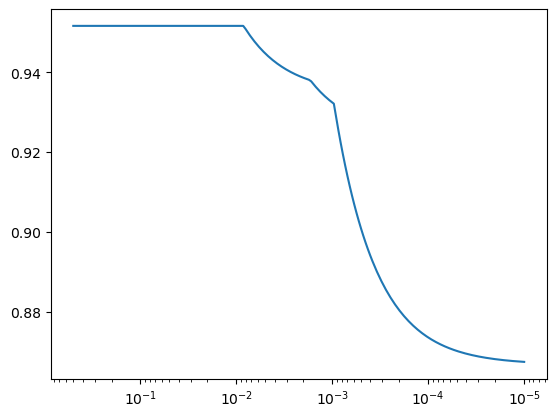

In [17]:
# Post process
A, b = mats_dict['EqOdd']
A_const = M_const


eps_vals = np.logspace(-0.3, -5, 200)
eps_used = []
acc_vals = []
for eps in eps_vals:
    res, _ = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
    acc_vals.append(1 - res.value)
    eps_used.append(eps)
    
f, axs = plt.subplots()
axs.semilogx(eps_used, acc_vals)
axs.invert_xaxis()

import pickle
pickle.dump([eps_used, acc_vals], open('postprocess.pkl', 'wb'))